# Familial DistilBERT Model Using Merged Data Batch 1 + Batch 2 Experiment 2 with undersampling

In [2]:
import ktrain
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from ktrain import text
import random
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

## 1. Loading the data and quick exploratory data analysis

In [7]:
merged_familial_df_batch_1 = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Familial_sentence_level_batch_1_jaccard.csv", encoding='utf-8')
merged_familial_df_batch_2 = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/Familial Plus_sentence_level_batch_2_jaccard.csv", encoding='utf-8')

merged_familial_df = pd.concat([merged_familial_df_batch_1, merged_familial_df_batch_2])

# Shuffle the merged dataset
merged_familial_df = shuffle(merged_familial_df, random_state=seed)

# Train-test split 
training_df, test_df = train_test_split(merged_familial_df, test_size=0.3, random_state=42, stratify=merged_familial_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [8]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (1851, 3) 
Test dataset shape: (794, 3)
Positive labels present in the dataset : 177  out of 1851 or 9.562398703403566%
Positive labels present in the test dataset : 76  out of 794 or 9.571788413098236%


In [9]:
print(training_df.shape)
print(test_df.shape)

(1851, 3)
(794, 3)


## 2. Experimental Design

In [10]:
X, y = training_df['sentence'], training_df['label']


# Check the distribution before undersampling
print(f"Original class distribution: {Counter(y)}")

strategy_1 = {0: int(0.92 * len(y)), 1: int(0.08 * len(y))}

# Step 1: Perform random undersampling on raw text data and labels
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# Step 1: Perform random oversampling to achieve 70% class 0 and 30% class 1
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)
X_resampled = X_resampled.flatten()  # Flatten back to 1D array

Original class distribution: Counter({0: 1674, 1: 177})


In [11]:
# Step 2: Split into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)



In [12]:
len(X_train)
len(y_test)

670

In [13]:
MAXLEN = 128

In [14]:
# X = training_df['sentence']
# y = training_df['label']

In [15]:
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 18, stratify=y)
# X_test.shape

In [16]:
model_name = 'distilbert-base-uncased'

In [17]:
best_val_loss = np.inf  # Initialize with a very large value for minimum loss
best_val_acc = 0  # Initialize with a very low accuracy
best_model = None  # Placeholder to store the best model

## cv

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import gc

# Define classes and class labels
classes = np.array([0, 1])
class_labels = list(training_df.label)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=class_labels)

# Print class weights
print(class_weights)

dict(zip(classes, class_weights))


[0.53181189 8.35869565]


{0: 0.5318118948824343, 1: 8.358695652173912}

In [12]:
# Number of folds for cross-validation
n_folds = 5
MAXLEN = 150
model_name = 'distilbert-base-uncased'

# Initialize stratified K-Fold
skf = StratifiedKFold(n_splits=n_folds)

# Placeholder for results
cv_results = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_folds}")

    # Split the data into training and validation sets using .iloc
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Convert to list format (if they are pandas Series)
    X_train_fold = X_train_fold.tolist()
    X_val_fold = X_val_fold.tolist()
    y_train_fold = y_train_fold.tolist()
    y_val_fold = y_val_fold.tolist()

    # Define classes and class labels
    classes = np.array([0, 1])
    class_labels = list(training_df.label)

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=class_labels)


    # Initialize the distillbert transformer for this fold
    distillbert_transformer = text.Transformer(model_name, maxlen=MAXLEN, class_names=[0, 1])

    # Preprocess the training and validation sets for the current fold
    training_set = distillbert_transformer.preprocess_train(X_train_fold, y_train_fold)
    validation_set = distillbert_transformer.preprocess_test(X_val_fold, y_val_fold)

    # Build the model
    distillbert_base_model = distillbert_transformer.get_classifier()

    # Initialize the learner
    distilbert_learner = ktrain.get_learner(
        distillbert_base_model, train_data=training_set, val_data=validation_set, batch_size=6
    )

    # Apply weight decay
    distilbert_learner.set_weight_decay(0.001)

    # Train the model with autofit and early stopping
    distilbert_learner.autofit(2e-5, 2, class_weight=dict(zip(classes, class_weights)))

    distilbert_learner.validate(class_names=distillbert_transformer.get_classes())


    # Access the validation loss and accuracy from the last epoch
    val_loss = distilbert_learner.history.history['val_loss'][-1]
    val_acc = distilbert_learner.history.history['val_accuracy'][-1]

    # Store the result for this fold
    print(f"Fold {fold+1} - Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
    cv_results.append((val_loss, val_acc))

    

    # Update the best model if the current one has a lower validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model = distilbert_learner.model  # Save the best model

    gc.collect()
    del distilbert_learner.model

# After all folds are done, compute mean and std of the performance
mean_val_acc = np.mean([x[1] for x in cv_results])
std_val_acc = np.std([x[1] for x in cv_results])

mean_val_loss = np.mean([x[0] for x in cv_results])
std_val_loss = np.std([x[0] for x in cv_results])

print(f"Mean Validation Accuracy: {mean_val_acc:.4f} (+/- {std_val_acc:.4f})")
print(f"Mean Validation Loss: {mean_val_loss:.4f} (+/- {std_val_loss:.4f})")

# Print the best model's validation performance
print(f"Best Model - Validation Accuracy: {best_val_acc:.4f}, Validation Loss: {best_val_loss:.4f}")

Fold 1/5
Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 54


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 55




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/2
984/984 [==============================] - 173s 168ms/step - loss: 0.5298 - accuracy: 0.7917 - val_loss: 0.5220 - val_accuracy: 0.7718
Epoch 2/2
47/47 [==============================] - 11s 193ms/step
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1391
           1       0.26      0.77      0.39        86

    accuracy                           0.86      1477
   macro avg       0.62      0.82      0.65      1477
weighted avg       0.94      0.86      0.89      1477

Fold 1 - Validation Accuracy: 0.8585, Validation Loss: 0.3655
Fold 2/5
preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 55


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 53




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/2
985/985 [==============================] - 183s 179ms/step - loss: 0.5292 - accuracy: 0.7763 - val_loss: 0.5198 - val_accuracy: 0.7791
Epoch 2/2
47/47 [==============================] - 11s 199ms/step
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1390
           1       0.24      0.78      0.37        86

    accuracy                           0.85      1476
   macro avg       0.61      0.81      0.64      1476
weighted avg       0.94      0.85      0.88      1476

Fold 2 - Validation Accuracy: 0.8455, Validation Loss: 0.3934
Fold 3/5
preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 56


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 21
	95percentile : 41
	99percentile : 51




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/2
985/985 [==============================] - 178s 173ms/step - loss: 0.5359 - accuracy: 0.7551 - val_loss: 0.4286 - val_accuracy: 0.8584
Epoch 2/2
47/47 [==============================] - 10s 166ms/step
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1390
           1       0.24      0.81      0.37        86

    accuracy                           0.84      1476
   macro avg       0.61      0.83      0.64      1476
weighted avg       0.94      0.84      0.87      1476

Fold 3 - Validation Accuracy: 0.8367, Validation Loss: 0.3976
Fold 4/5
preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 53


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 22
	95percentile : 40
	99percentile : 56




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/2
985/985 [==============================] - 187s 181ms/step - loss: 0.5364 - accuracy: 0.7682 - val_loss: 0.4208 - val_accuracy: 0.8408
Epoch 2/2
486/985 [=============>................] - ETA: 1:22 - loss: 0.4457 - accuracy: 0.8254

In [52]:
import os
from datetime import datetime

# Get current time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create 'performance' folder if it doesn't exist
if not os.path.exists('performance'):
    os.makedirs('performance')

# Evaluate the best model on the holdout set
distillbert_test_data = test_df['sentence'].tolist()
distillbert_test_label = test_df['label'].tolist()

# Preprocess the holdout data
holdout_set = distillbert_transformer.preprocess_test(distillbert_test_data, distillbert_test_label)

# Create a new learner for the best model and evaluate it on the holdout set
best_predictor = ktrain.get_predictor(best_model, preproc=distillbert_transformer)


# Print the confusion matrix and classification report for the best model on the holdout set
y_pred_distillbert = best_predictor.predict(distillbert_test_data)
y_pred_distillbert = [int(x) for x in y_pred_distillbert]

# Classification report and confusion matrix for holdout set
holdout_report = classification_report(distillbert_test_label, y_pred_distillbert)
print(holdout_report)
tn, fp, fn, tp = confusion_matrix(distillbert_test_label, y_pred_distillbert).ravel()
holdout_matrix = 'True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp)

print(f"Holdout Set - Classification Report:\n{holdout_report}")
print(holdout_matrix)

# Filename for metrics
filename = 'performance/metrics.txt'  # Using a fixed filename to append to

# Save classification report and confusion matrix for holdout set
# Open file in append mode; it will create the file if it doesn't exist
with open(filename, 'a') as f:
    f.write("\n\n")
    f.write(current_time)
    f.write("\n\n")
    f.write("Holdout Set - Classification Report:\n")
    f.write(str(holdout_report))
    f.write("\n\n")
    f.write("Holdout Set - Confusion Matrix:\n")
    f.write(holdout_matrix)


preprocessing test...
language: en
test sequence lengths:
	mean : 21
	95percentile : 43
	99percentile : 64


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       240
           1       0.00      0.00      0.00        25

    accuracy                           0.91       265
   macro avg       0.45      0.50      0.48       265
weighted avg       0.82      0.91      0.86       265

Holdout Set - Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       240
           1       0.00      0.00      0.00        25

    accuracy                           0.91       265
   macro avg       0.45      0.50      0.48       265
weighted avg       0.82      0.91      0.86       265

True Negative: 240, False Positive: 0, False Negative: 25, True Positive: 0


## back to ktrain

In [18]:
distillbert_transformer = text.Transformer(model_name, maxlen=MAXLEN, class_names=[0,1])
training_set = distillbert_transformer.preprocess_train(X_train.tolist(), y_train.tolist())
validation_set = distillbert_transformer.preprocess_test(X_test.tolist(), y_test.tolist())
distillbert_base_model = distillbert_transformer.get_classifier()


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

preprocessing train...
language: en
train sequence lengths:
	mean : 25
	95percentile : 50
	99percentile : 74


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 24
	95percentile : 45
	99percentile : 74


In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define classes and class labels
classes = np.array([0, 1])
class_labels = list(training_df.label)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=class_labels)

# Print class weights
print(class_weights)

class_weights = dict(zip(classes, class_weights))


[0.55286738 5.22881356]


In [20]:
# Build BERT model
# model = text.text_classifier('distilbert', train_data=(X_train, y_train), preproc=distillbert_transformer)
distillbert_learner = ktrain.get_learner(distillbert_base_model, train_data=training_set, val_data=validation_set, batch_size=6)
distillbert_learner.autofit(2e-5, early_stopping=4)
# distillbert_learner.set_weight_decay(0.001)
# distillbert_learner.autofit(2.27E-06, early_stopping=4, class_weight=class_weights)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/1024
447/447 [==============================] - 183s 359ms/step - loss: 0.3721 - accuracy: 0.8447 - val_loss: 0.2235 - val_accuracy: 0.9209
Epoch 2/1024
447/447 [==============================] - 80s 178ms/step - loss: 0.1888 - accuracy: 0.9354 - val_loss: 0.1561 - val_accuracy: 0.9463
Epoch 3/1024
447/447 [==============================] - 94s 209ms/step - loss: 0.1256 - accuracy: 0.9619 - val_loss: 0.1326 - val_accuracy: 0.9552
Epoch 4/1024
447/447 [==============================] - 98s 218ms/step - loss: 0.0920 - accuracy: 0.9746 - val_loss: 0.1328 - val_accuracy: 0.9582
Epoch 5/1024
447/447 [==============================] - 98s 219ms/step - loss: 0.0700 - accuracy: 0.9828 - val_loss: 0.1054 - val_accuracy: 0.9657
Epoch 6/1024
447/447 [==============================] - 98s 219ms/step - loss: 0.0638 - accuracy: 0.9828 - val_loss: 0.0851 - val_a

In [21]:
distillbert_learner.validate(class_names=distillbert_transformer.get_classes())

21/21 [==============================] - 8s 256ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       335
           1       0.95      1.00      0.97       335

    accuracy                           0.97       670
   macro avg       0.97      0.97      0.97       670
weighted avg       0.97      0.97      0.97       670



array([[317,  18],
       [  0, 335]])

In [22]:
distillbert_learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
distillbert_predictor = ktrain.get_predictor(distillbert_learner.model, preproc=distillbert_transformer)

In [24]:
Counter(test_df['label'])

Counter({0: 718, 1: 76})

In [25]:
distillbert_test_data = test_df['sentence'].tolist()
distillbert_test_label = test_df['label'].tolist()

In [26]:
y_pred_distillbert = distillbert_predictor.predict(distillbert_test_data)

In [27]:
y_pred_distillbert = [int(x) for x in y_pred_distillbert]

In [28]:
tn, fp, fn, tp = confusion_matrix(distillbert_test_label, y_pred_distillbert).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))

True Negative: 677, False Positive: 41, False Negative: 43, True Positive: 33


In [29]:
print('  Classification Report:\n',classification_report(distillbert_test_label,y_pred_distillbert),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       718
           1       0.45      0.43      0.44        76

    accuracy                           0.89       794
   macro avg       0.69      0.69      0.69       794
weighted avg       0.89      0.89      0.89       794
 



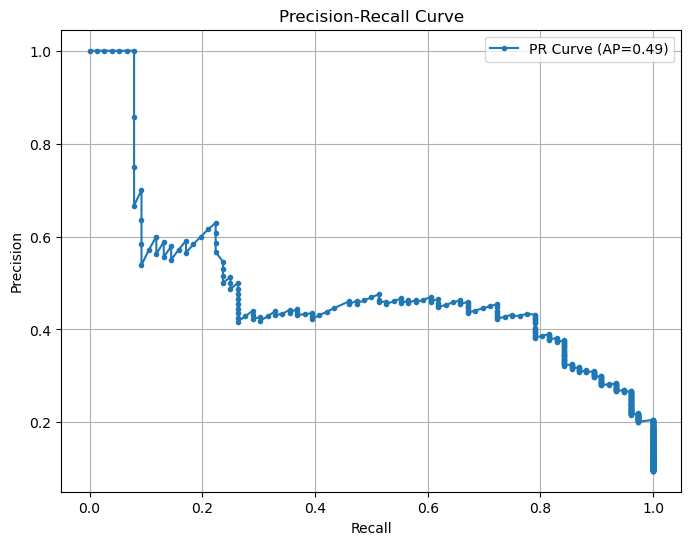

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for the validation set (assuming you have validation data `X_val_fold` and `y_val_fold`)
y_pred_proba_distillbert = distillbert_predictor.predict_proba(distillbert_test_data)

# Get the true labels
distillbert_test_label = test_df['label'].tolist()

# Assuming binary classification, use the probabilities of the positive class (class 1)
pred_probs_positive = y_pred_proba_distillbert[:, 1]

# Compute precision, recall, and threshold values
precision, recall, thresholds = precision_recall_curve(distillbert_test_label, pred_probs_positive)

# Compute average precision score
avg_precision = average_precision_score(distillbert_test_label, pred_probs_positive)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


  Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.50      0.55        26
           1       0.59      0.70      0.64        27

    accuracy                           0.60        53
   macro avg       0.61      0.60      0.60        53
weighted avg       0.61      0.60      0.60        53
 



In [24]:
# distillbert_predictor.save('../../model/first_generation_distilbert_base_uncased_model_10102020') # 256 MB

In [23]:
print("AUC roc score for distillbert model: ", roc_auc_score(distillbert_test_label,y_pred_distillbert))

AUC roc score for distillbert model:  0.5970833333333333
